## Inverse Kinematics

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import math as m
import random
import csv
import cv2
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

l1 = l2 = l3 = 7

Generating the Work Space

In [2]:
def threeLinkManipulatorFile():
    data = []
    for i in range(1, 150000):
        q1 = round(random.uniform(0, m.pi), 2)
        q2 = round(random.uniform(-m.pi, 0), 2)
        q3 = round(random.uniform(-m.pi / 2, m.pi / 2))

        theta_o = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
        x_s = round(l1 * m.cos(q1) + l2 * m.cos(q1 + q2) + l3 * m.cos(q1 + q2 + q3), 2)
        y_s = round(l1 * m.sin(q1) + l2 * m.sin(q1 + q2) + l3 * m.sin(q1 + q2 + q3), 2)
        data.append([x_s, y_s, theta_o, q1, q2, q3])

    df = pd.DataFrame(data, columns=['x_scaled', 'y_scaled', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated'])

    df.to_csv('Three Link.csv', index = False)

threeLinkManipulatorFile()

Visualising the Work Space

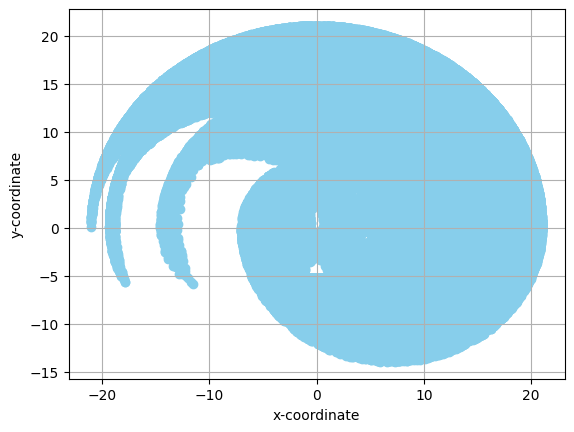

In [2]:
def displayWorkSpace():
    data = pd.read_csv('Three Link.csv')
    plt.scatter(data['x_scaled'], data['y_scaled'], color = 'skyblue')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.grid()

displayWorkSpace()

Text(0.5, 1.0, 'Work Space of the 3 Link Manipulator')

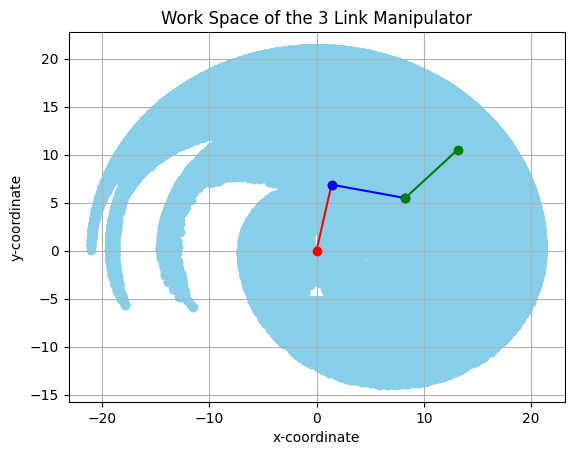

In [6]:
displayWorkSpace()
point_1_x = l1 * m.cos(1.37)
point_1_y = l1 * m.sin(1.37)
point_2_x = l1 * m.cos(1.37) + l2 * m.cos(1.37 - 1.57)
point_2_y = l1 * m.sin(1.37) + l2 * m.sin(1.37 - 1.57)
point_3_x = l1 * m.cos(1.37) + l2 * m.cos(1.37 - 1.57) + l3 * m.cos(1.37 - 1.57 + 1)
point_3_y = l1 * m.sin(1.37) + l2 * m.sin(1.37 - 1.57) + l3 * m.sin(1.37 - 1.57 + 1)
x_values_1 = [0, point_1_x]
y_values_1 = [0, point_1_y]
plt.plot(x_values_1, y_values_1, 'ro', linestyle='-')
x_values_2 = [point_1_x, point_2_x]
y_values_2 = [point_1_y, point_2_y]
plt.plot(x_values_2, y_values_2, 'bo', linestyle='-')
x_values_3 = [point_2_x, point_3_x]
y_values_3 = [point_2_y, point_3_y]
plt.plot(x_values_3, y_values_3, 'go', linestyle='-')
plt.title("Work Space of the 3 Link Manipulator")

Training the Artificial Neural Network Model

In [10]:
data = pd.read_csv('Three Link.csv')

x = data.iloc[:, 0:3].values
y = data.iloc[:, 3:].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

classifier = Sequential()
classifier.add(Dense(units = 3, input_dim = 3, kernel_initializer = 'uniform'))
classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'linear'))
classifier.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])

history = classifier.fit(x_train, y_train, epochs = 150, validation_split = 0.1, shuffle = True)

Epoch 1/150
3375/3375 [==============================] - 5s 1ms/step - loss: 0.1380 - accuracy: 0.9349 - val_loss: 0.0350 - val_accuracy: 0.9547
Epoch 2/150
3375/3375 [==============================] - 5s 1ms/step - loss: 0.0305 - accuracy: 0.9636 - val_loss: 0.0274 - val_accuracy: 0.9701
Epoch 3/150
3375/3375 [==============================] - 4s 1ms/step - loss: 0.0242 - accuracy: 0.9709 - val_loss: 0.0240 - val_accuracy: 0.9760
Epoch 4/150
3375/3375 [==============================] - 5s 1ms/step - loss: 0.0207 - accuracy: 0.9741 - val_loss: 0.0153 - val_accuracy: 0.9749
Epoch 5/150
3375/3375 [==============================] - 8s 2ms/step - loss: 0.0182 - accuracy: 0.9779 - val_loss: 0.0159 - val_accuracy: 0.9821
Epoch 6/150
3375/3375 [==============================] - 12s 4ms/step - loss: 0.0170 - accuracy: 0.9798 - val_loss: 0.0254 - val_accuracy: 0.9787
Epoch 7/150
3375/3375 [==============================] - 12s 4ms/step - loss: 0.0157 - accuracy: 0.9819 - val_loss: 0.0152 - val_

Model Evaluation

In [11]:
test_loss, test_acc = classifier.evaluate(x_test, y_test)
print('Testing the Model :')
print('Testing Loss =', test_loss)
print('Testing Accuracy =', test_acc)

938/938 [==============================] - 2s 2ms/step - loss: 0.0037 - accuracy: 0.9929
Testing the Model :
Testing Loss = 0.0036615030840039253
Testing Accuracy = 0.992900013923645


Plot of Model Accuracy

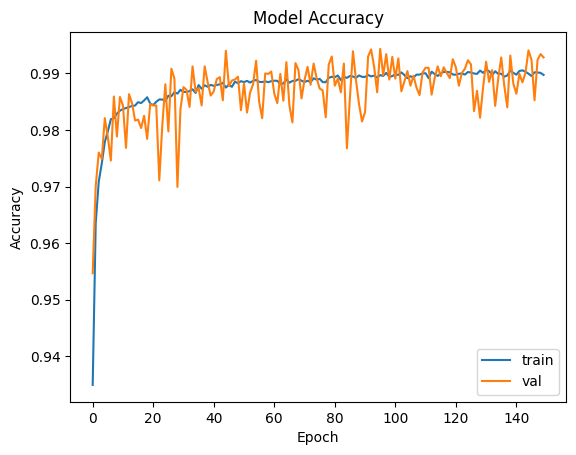

<Figure size 2200x2200 with 0 Axes>

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.figure(figsize=(22,22))
plt.show()
# plt.savefig('NN-Model_Accuracy.png')

Plot of Model Loss

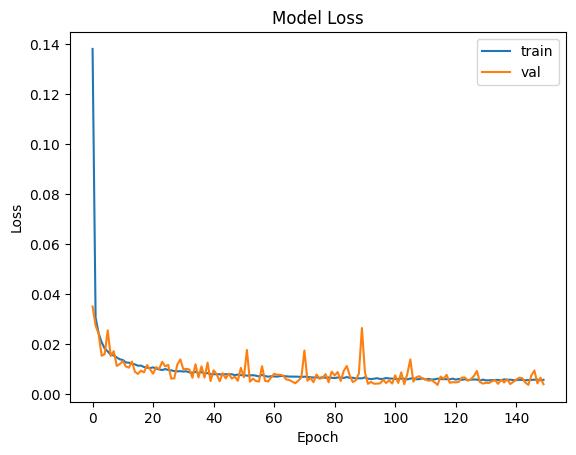

<Figure size 2200x2200 with 0 Axes>

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.figure(figsize=(22,22))
plt.show()
# plt.savefig('NN-Model_Loss.png')

Function for plotting a square representing the Confined Work Space

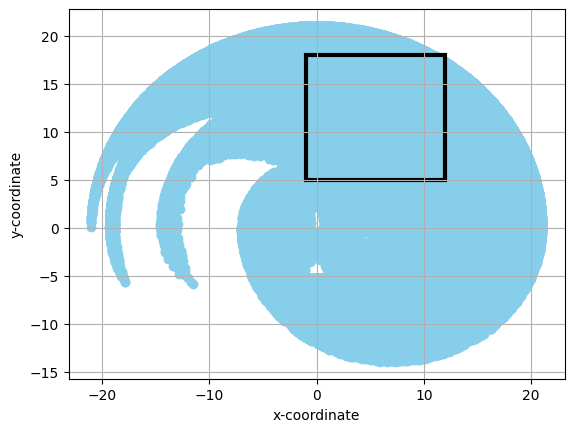

In [14]:
xmin = -1
xmax = 12
ymin = 5
ymax = 18

def displayConfinedWorkSpace():
    rect=mpatches.Rectangle((xmin,ymin),13,13, 
                            fill = False,
                            color = "black",
                            linewidth = 3)
    plt.gca().add_patch(rect)

displayWorkSpace()
displayConfinedWorkSpace()

## GENERATING A PLOT FROM INPUT CSV FILE

In [16]:
if not os.path.exists("CSV_Generated"):
    os.makedirs("CSV_Generated")

Generating a CSV File for a Circle

In [17]:
def circleFile():
    with open('CSV_Generated/Random Generate_Circle.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        Xc = 10
        Yc = 10
        r = 5
        data_points = 100
        points = np.linspace(0,360,num = data_points)
        x = []
        y = []
        for p in points:
            i=Xc + r * m.cos(np.radians(p))
            x.append(i)
            j=Yc + r * m.sin(np.radians(p))
            y.append(j)

        xmin = -1
        xmax = 12
        ymin = 5
        ymax = 18

        min_xe = np.min(x)
        max_xe = np.max(x)
        min_ye = np.min(y)
        max_ye = np.max(y)

        scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
        scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))
            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)     
    csvFile.close()

circleFile()

1/1 [==============================] - 0s 22ms/step


Plot a Circle Using its CSV File

<Figure size 1500x1500 with 0 Axes>

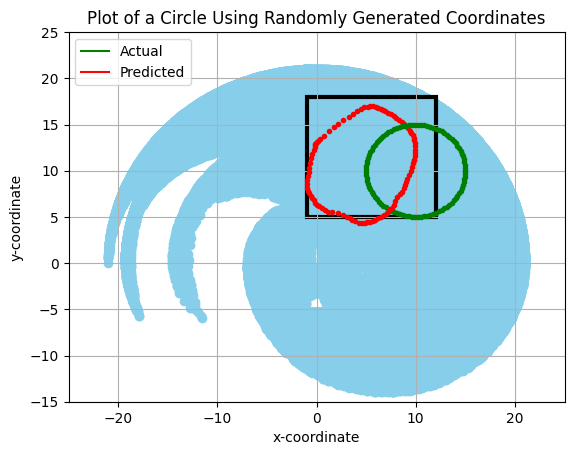

<Figure size 1500x1500 with 0 Axes>

In [18]:
filename = 'CSV_Generated/Random Generate_Circle.csv'
data = np.loadtxt(filename, delimiter=",", skiprows=1)

x = [row[0] for row in data]
y = [row[1] for row in data]

x_s = [row[12] for row in data]
y_s = [row[13] for row in data]

displayWorkSpace()
displayConfinedWorkSpace()
for i in range(len(data)):
    plt.plot(x[i], y[i], 'go', markersize = 3)
    plt.plot(x_s[i], y_s[i], 'ro', markersize = 3)
    plt.xlim([-25, 25])
    plt.ylim([-15, 25])
    
plt.plot(20, 20, 'g', label='Actual')
plt.plot(20, 20, 'r', label='Predicted')
plt.title('Plot of a Circle Using Randomly Generated Coordinates')
plt.legend(loc='upper left')
plt.figure(figsize=(15,15))
# plt.savefig('Random Generate_Circle Plot.png')

In [19]:
def getPerformanceModel(filename):
    data=pd.read_csv(filename)

    X_true=data['x_original']
    X_pred=data['x_predicted']
    Y_true=data['y_original']
    Y_pred=data['y_predicted']
    q1_true=data['q1_estimated']
    q1_pred=data['q1_predicted']
    q2_true=data['q2_estimated']
    q2_pred=data['q2_predicted']
    q3_true=data['q3_estimated']
    q3_pred=data['q3_predicted']
    theta_true=data['theta_scaled']
    theta_pred=data['theta_predicted']

    mse_x=mean_squared_error(X_true,X_pred)
    mse_y=mean_squared_error(Y_true,Y_pred) 
    mse_q1=mean_squared_error(q1_true,q1_pred)
    mse_q2=mean_squared_error(q2_true,q2_pred) 
    mse_q3=mean_squared_error(q3_true,q3_pred)
    mse_theta=mean_squared_error(theta_true,theta_pred) 
    print('Mean Squared Error in x  :', mse_x) 
    print('Mean Squared Error in y  :', mse_y)
    print('Mean Squared Error in q1 :', mse_q1) 
    print('Mean Squared Error in q2 :', mse_q2)
    print('Mean Squared Error in q3 :', mse_q3)
    print('Mean Squared Error in theta :', mse_theta)
    print()

    rmse_x = m.sqrt(mse_x)
    rmse_y = m.sqrt(mse_y)
    rmse_q1 = m.sqrt(mse_q1)
    rmse_q2 = m.sqrt(mse_q2)
    rmse_q3 = m.sqrt(mse_q3)
    rmse_theta = m.sqrt(mse_theta)
    print('Root Mean Squared Error in x :', rmse_x) 
    print('Root Mean Squared Error in y :', rmse_y)
    print('Root Mean Squared Error in q1 :', rmse_q1) 
    print('Root Mean Squared Error in q2 :', rmse_q2)
    print('Root Mean Squared Error in q3 :', rmse_q3)
    print('Root Mean Squared Error in theta :', rmse_theta)
    print()

    mae_x=mean_absolute_error(X_true,X_pred)
    mae_y=mean_absolute_error(Y_true,Y_pred)
    mae_q1=mean_absolute_error(q1_true,q1_pred)
    mae_q2=mean_absolute_error(q2_true,q2_pred)
    mae_q3=mean_absolute_error(q3_true,q3_pred)
    mae_theta=mean_absolute_error(theta_true,theta_pred)
    print('Mean Absolute Error in x :', mae_x) 
    print('Mean Absolute Error in y :', mae_y)
    print('Mean Absolute Error in q1 :', mae_q1) 
    print('Mean Absolute Error in q2 :', mae_q2)
    print('Mean Absolute Error in q3 :', mae_q3)
    print('Mean Absolute Error in theta :', mae_theta)
    print()

    print('R2 Score for x :', r2_score(X_true, X_pred)) 
    print('R2 Score for y :', r2_score(Y_true, Y_pred))
    print('R2 Score for q1 :', r2_score(q1_true, q1_pred)) 
    print('R2 Score for q2 :', r2_score(q2_true, q2_pred))
    print('R2 Score for q3 :', r2_score(q3_true, q3_pred)) 
    print('R2 Score for theta :', r2_score(theta_true, theta_pred))
    print()

In [21]:
getPerformanceModel('CSV_Generated/Random Generate_Circle.csv')

Mean Squared Error in x  : 0.5089558636282541
Mean Squared Error in y  : 0.6010563362782901
Mean Squared Error in q1 : 1.9679108468455508
Mean Squared Error in q2 : 6.404174988796237e-07
Mean Squared Error in q3 : 1.9680401780874122
Mean Squared Error in theta : 1.5812635333574667

Root Mean Squared Error in x : 0.7134114266173861
Root Mean Squared Error in y : 0.7752782315261342
Root Mean Squared Error in q1 : 1.4028224573500208
Root Mean Squared Error in q2 : 0.0008002608942586309
Root Mean Squared Error in q3 : 1.4028685533888812
Root Mean Squared Error in theta : 1.2574830151367717

Mean Absolute Error in x : 0.5295376282112508
Mean Absolute Error in y : 0.6574894227924609
Mean Absolute Error in q1 : 1.1911203688403937
Mean Absolute Error in q2 : 0.000631978826373743
Mean Absolute Error in q3 : 1.1911571261522713
Mean Absolute Error in theta : 0.9894024971493437

R2 Score for x : 0.9596786798472368
R2 Score for y : 0.951429791007815
R2 Score for q1 : -7.526944548773381
R2 Score for

Generating a CSV File for the word "MANIT"

In [23]:
def manitFile():
    x = []
    y = []
    # for M
    arr=np.linspace(7,10,100)
    for j in arr:
        i = 7
        x.append(i-1)
        y.append(j)

    arr=np.linspace(7,8,100)
    for i in arr:
        j = -3*i + 31
        x.append(i-1)
        y.append(j)

    arr=np.linspace(8,9,100)
    for i in arr:
        j = 3*i - 17
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(7,10,100)
    for j in arr:
        i = 9
        x.append(i-1)
        y.append(j)

    # for A
    arr=np.linspace(10,11,100)
    for i in arr:
        j = 3*i - 23
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(11,12,100)
    for i in arr:
        j= -3*i + 43
        x.append(i-1)
        y.append(j)

    arr=np.linspace(10,12,100)
    for i in arr:
        j = 8
        x.append(i-1)
        y.append(j)

    # for N
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 13
        x.append(i-1)
        y.append(j)

    arr=np.linspace(13,15,100)
    for i in arr:
        j = -1.5*i + 29.5
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 15
        x.append(i-1)
        y.append(j)


    # for I
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 16
        x.append(i-1)
        y.append(j)
        
    # for T
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 17
        x.append(i)
        y.append(j)
            
    arr=np.linspace(16,18,100)
    for i in arr:
        j=10
        x.append(i)
        y.append(j)

    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_xe = np.min(x)
    max_xe = np.max(x)
    min_ye = np.min(y)
    max_ye = np.max(y)

    scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
    scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

    with open('CSV_Generated/Random Generate_MANIT.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))

            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)
    csvFile.close()
manitFile()

1/1 [==============================] - 0s 19ms/step


Function for Plotting (After Transformation of Axes and Scaling) Using the CSV File

In [24]:
def plotCoordinateFile(FilePath, PlotTitle):
    filename = FilePath
    data = np.loadtxt(filename, delimiter = ",", skiprows = 1)

    x = [row[0] for row in data]
    y = [row[1] for row in data]

    x_s = [row[12] for row in data]
    y_s = [row[13] for row in data]
    
    i = 1
    displayWorkSpace()
    displayConfinedWorkSpace()

    for i in range(len(data)):
        plt.xlim([-25,30])
        plt.ylim([-15,20])
        plt.plot(x[i], y[i], 'go', markersize = 1.5)
        plt.plot(x_s[i], y_s[i], 'ro', markersize = 1.5)
    
    plt.plot(20, 20, 'g', label='Actual')
    plt.plot(20, 20, 'r', label='Predicted')
    plt.title(PlotTitle)
    plt.legend(loc='upper left')
    plt.figure(figsize=(15,15))

Plot the word MANIT Using its CSV File after Scaling and Transformation of Axes

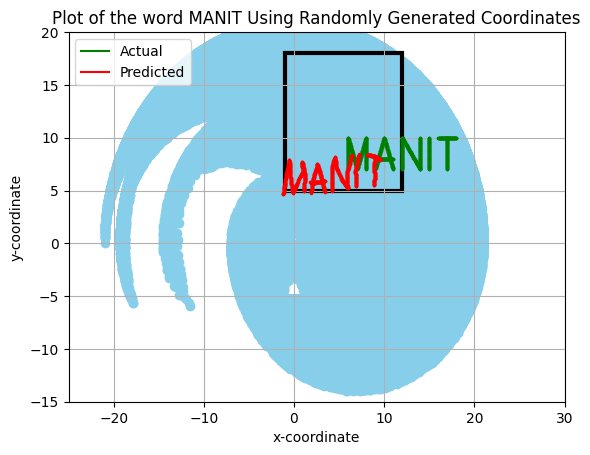

<Figure size 1500x1500 with 0 Axes>

In [25]:
plotCoordinateFile("CSV_Generated/Random Generate_MANIT.csv", 'Plot of the word MANIT Using Randomly Generated Coordinates')

In [26]:
getPerformanceModel("CSV_Generated/Random Generate_MANIT.csv")

Mean Squared Error in x  : 0.0870144333074333
Mean Squared Error in y  : 0.15236065268065266
Mean Squared Error in q1 : 1.754828096156446
Mean Squared Error in q2 : 6.133102609464107e-07
Mean Squared Error in q3 : 1.7547737772721674
Mean Squared Error in theta : 0.8465687842343644

Root Mean Squared Error in x : 0.2949820898078955
Root Mean Squared Error in y : 0.3903340270597129
Root Mean Squared Error in q1 : 1.3246992474356003
Root Mean Squared Error in q2 : 0.000783141277769478
Root Mean Squared Error in q3 : 1.3246787449310748
Root Mean Squared Error in theta : 0.9200917259895148

Mean Absolute Error in x : 0.23786705516705514
Mean Absolute Error in y : 0.30684801864801864
Mean Absolute Error in q1 : 1.1526326938274185
Mean Absolute Error in q2 : 0.0005257311287862784
Mean Absolute Error in q3 : 1.1526021296772087
Mean Absolute Error in theta : 0.7341592847089216

R2 Score for x : 0.9934487694064988
R2 Score for y : 0.81727533788506
R2 Score for q1 : -7.963506801143817
R2 Score fo

Generating a CSV File for the word "ROBOT"

In [27]:
def makeCircle(Xcentre, Ycentre, radius, start, end, x, y):
    Xc = Xcentre
    Yc = Ycentre
    r = radius
    data_points = 100
    points = np.linspace(start,end,num =data_points)
    for p in points:
        i=Xc + r*m.cos(np.radians(p))
        j=Yc + r*m.sin(np.radians(p))
        x.append(i)
        y.append(j)

def robotFile():
    x = []
    y = []

    # for R
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 5
        x.append(i)
        y.append(j)
    
    makeCircle(5, 9, 1, -90, 90, x, y)

    arr=np.linspace(5,6,100)
    for i in arr:
        j= -i + 13
        x.append(i)
        y.append(j)

    # for O
    makeCircle(8, 8, 1, 0, 360, x, y)

    # for B
    arr=np.linspace(6,10,100) # 6, 10
    for j in arr:
        i= 10 # 10
        x.append(i)
        y.append(j)
        
    makeCircle(10, 7, 1, -90, 90, x, y)
        
    makeCircle(10, 9, 1, -90, 90, x, y)
        
    # for O
    makeCircle(13, 8, 1, 0, 360, x, y)

    # for T
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 15
        x.append(i)
        y.append(j)
    
    arr=np.linspace(14,16,100)
    for i in arr:
        j=10
        x.append(i)
        y.append(j)


    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_xe = np.min(x)
    max_xe = np.max(x)
    min_ye = np.min(y)
    max_ye = np.max(y)

    scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
    scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

    with open('CSV_Generated/Random Generate_ROBOT.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))

            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)
    csvFile.close()
robotFile()

1/1 [==============================] - 0s 21ms/step


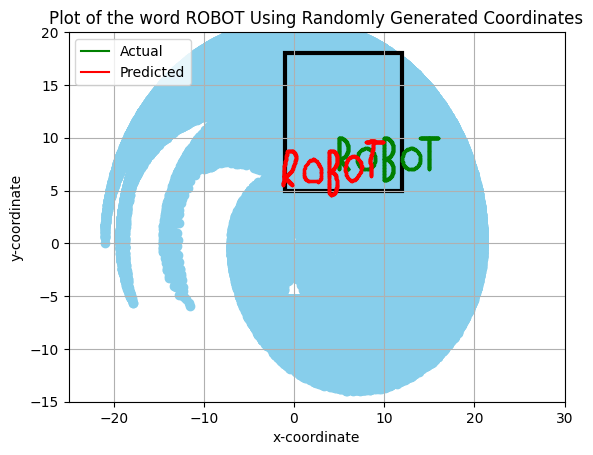

<Figure size 1500x1500 with 0 Axes>

In [28]:
plotCoordinateFile("CSV_Generated/Random Generate_ROBOT.csv", 'Plot of the word ROBOT Using Randomly Generated Coordinates')

In [29]:
getPerformanceModel("CSV_Generated/Random Generate_ROBOT.csv")

Mean Squared Error in x  : 0.06172923131480426
Mean Squared Error in y  : 0.20283120043660138
Mean Squared Error in q1 : 2.588964147078229
Mean Squared Error in q2 : 2.8559395726719396e-07
Mean Squared Error in q3 : 2.5889858417770792
Mean Squared Error in theta : 1.6011995409208029

Root Mean Squared Error in x : 0.24845368042112853
Root Mean Squared Error in y : 0.4503678501365316
Root Mean Squared Error in q1 : 1.6090258379150502
Root Mean Squared Error in q2 : 0.0005344099150157995
Root Mean Squared Error in q3 : 1.6090325794641571
Root Mean Squared Error in theta : 1.265385135411667

Mean Absolute Error in x : 0.20136346593417148
Mean Absolute Error in y : 0.35520282917995005
Mean Absolute Error in q1 : 1.449850913717798
Mean Absolute Error in q2 : 0.00043023524257605083
Mean Absolute Error in q3 : 1.4498522185552334
Mean Absolute Error in theta : 0.9776712753854364

R2 Score for x : 0.9952382448510895
R2 Score for y : 0.8310526900218456
R2 Score for q1 : -11.87309434987833
R2 Sco

Plot a Circle Using its CSV File after Scaling and Transformation of Axes

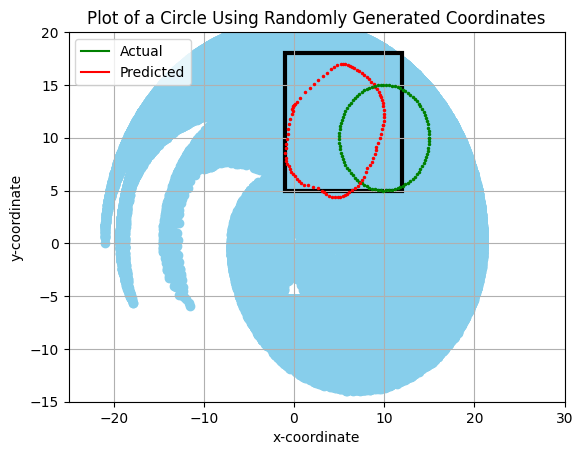

<Figure size 1500x1500 with 0 Axes>

In [30]:
plotCoordinateFile("CSV_Generated/Random Generate_Circle.csv", 'Plot of a Circle Using Randomly Generated Coordinates')

In [32]:
getPerformanceModel("CSV_Generated/Random Generate_Circle.csv")

Mean Squared Error in x  : 0.5089558636282541
Mean Squared Error in y  : 0.6010563362782901
Mean Squared Error in q1 : 1.9679108468455508
Mean Squared Error in q2 : 6.404174988796237e-07
Mean Squared Error in q3 : 1.9680401780874122
Mean Squared Error in theta : 1.5812635333574667

Root Mean Squared Error in x : 0.7134114266173861
Root Mean Squared Error in y : 0.7752782315261342
Root Mean Squared Error in q1 : 1.4028224573500208
Root Mean Squared Error in q2 : 0.0008002608942586309
Root Mean Squared Error in q3 : 1.4028685533888812
Root Mean Squared Error in theta : 1.2574830151367717

Mean Absolute Error in x : 0.5295376282112508
Mean Absolute Error in y : 0.6574894227924609
Mean Absolute Error in q1 : 1.1911203688403937
Mean Absolute Error in q2 : 0.000631978826373743
Mean Absolute Error in q3 : 1.1911571261522713
Mean Absolute Error in theta : 0.9894024971493437

R2 Score for x : 0.9596786798472368
R2 Score for y : 0.951429791007815
R2 Score for q1 : -7.526944548773381
R2 Score for

## GENERATING A PLOT FROM INPUT IMAGE FILE

In [33]:
if not os.path.exists("Image_Generated"):
    os.makedirs("Image_Generated")

Function for Generating a CSV File from an Image

In [38]:
def generateCoordinateFile(FilePath, RepositoryName, name):
    image = cv2.imread(FilePath)

    target_color = (0, 0, 0)
    x = []
    y = []
    height, width, _ = image.shape
    for j in range(height):
        for i in range(width):
            pixel_color = tuple(image[j, i])
            if pixel_color == target_color:
                x.append(i)
                y.append(height - j)

    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_x = np.min(x)
    max_x = np.max(x)
    min_y = np.min(y)
    max_y = np.max(y)

    scaling_factor_x = 10 * (xmax - xmin) / (max_x - min_x)
    scaling_factor_y = 10 * (ymax - ymin) / (max_y - min_y)

    output_file = str(RepositoryName) + "/Image Generate_" + str(name) + ".csv"
    with open(output_file, "w", newline='') as csvfile:
        fieldnames = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv_writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        csv_writer.writeheader()

        for k in range(len(x)):
            i = x[k] / 10
            j = y[k] / 10
            theta=m.degrees(m.atan(j / i))

            new_x=np.array([[i, j, theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            x_s = (x_p - min_x / 10) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            y_s = (y_p - min_y / 10) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin

            csv_writer.writerow({'x_original': i, 'y_original': j, 'theta_scaled': theta, 'q1_estimated': q1, 'q2_estimated': q2, 'q3_estimated': q3, 'x_predicted': x_p, 'y_predicted': y_p, 'theta_predicted': theta_p, 'q1_predicted': q1_p, 'q2_predicted': q2_p, 'q3_predicted': q3_p, 'x_scaled': x_s, 'y_scaled': y_s})

Plotting the word "MANIT" from it's Image

In [39]:
generateCoordinateFile('Images/Image_MANIT.png', 'Image_Generated', 'MANIT')

1/1 [==============================] - 0s 51ms/step


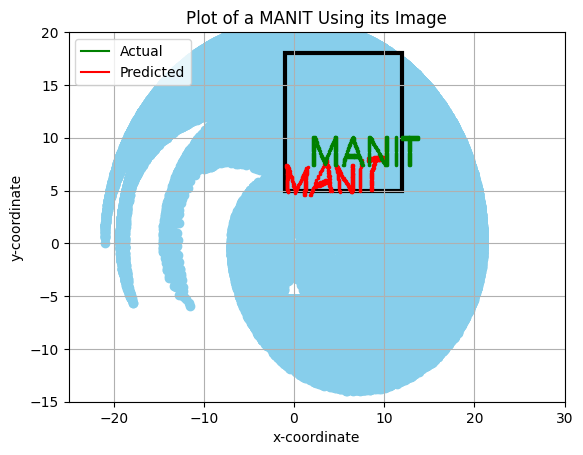

<Figure size 1500x1500 with 0 Axes>

In [40]:
plotCoordinateFile("Image_Generated/Image Generate_MANIT.csv", 'Plot of a MANIT Using its Image')

In [41]:
getPerformanceModel("Image_Generated/Image Generate_MANIT.csv")

Mean Squared Error in x  : 0.0740003683241252
Mean Squared Error in y  : 0.12227900552486187
Mean Squared Error in q1 : 3.064373238465503
Mean Squared Error in q2 : 2.188764636809118e-07
Mean Squared Error in q3 : 3.0644544442157216
Mean Squared Error in theta : 2.3910026340643253

Root Mean Squared Error in x : 0.2720300871670727
Root Mean Squared Error in y : 0.34968415109189876
Root Mean Squared Error in q1 : 1.7505351291720779
Root Mean Squared Error in q2 : 0.00046784234917428307
Root Mean Squared Error in q3 : 1.7505583235687183
Root Mean Squared Error in theta : 1.546286724402795

Mean Absolute Error in x : 0.2113075506445672
Mean Absolute Error in y : 0.2672744014732965
Mean Absolute Error in q1 : 1.576543248731289
Mean Absolute Error in q2 : 0.00037526152723996067
Mean Absolute Error in q3 : 1.5765641963957262
Mean Absolute Error in theta : 1.2436526090245625

R2 Score for x : 0.9943892893514152
R2 Score for y : 0.8238327537454149
R2 Score for q1 : -13.258600136641812
R2 Score

Plotting the word "ROBOT" from it's Image

In [42]:
generateCoordinateFile('Images/Image_ROBOT.png', 'Image_Generated', 'ROBOT')

1/1 [==============================] - 0s 15ms/step


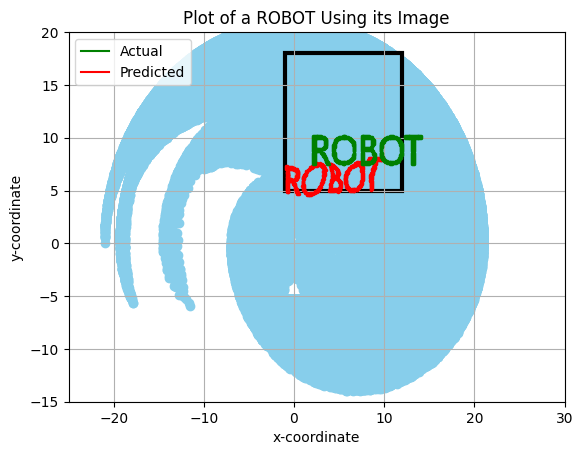

<Figure size 1500x1500 with 0 Axes>

In [43]:
plotCoordinateFile("Image_Generated/Image Generate_ROBOT.csv", 'Plot of a ROBOT Using its Image')

In [44]:
getPerformanceModel("Image_Generated/Image Generate_ROBOT.csv")

Mean Squared Error in x  : 0.0888348676639816
Mean Squared Error in y  : 0.11107710011507482
Mean Squared Error in q1 : 2.9539636687967956
Mean Squared Error in q2 : 2.1019117150054776e-07
Mean Squared Error in q3 : 2.9539110964207738
Mean Squared Error in theta : 2.2038592111399224

Root Mean Squared Error in x : 0.29805178688271877
Root Mean Squared Error in y : 0.33328231293465727
Root Mean Squared Error in q1 : 1.718709885000024
Root Mean Squared Error in q2 : 0.0004584661072539035
Root Mean Squared Error in q3 : 1.7186945907928999
Root Mean Squared Error in theta : 1.4845400672059756

Mean Absolute Error in x : 0.24228998849252012
Mean Absolute Error in y : 0.2565707710011507
Mean Absolute Error in q1 : 1.5562395666379165
Mean Absolute Error in q2 : 0.000373256456093542
Mean Absolute Error in q3 : 1.5562282911136203
Mean Absolute Error in theta : 1.192452999345629

R2 Score for x : 0.9934336282551947
R2 Score for y : 0.8590934221272852
R2 Score for q1 : -12.953115563752666
R2 Scor

Plotting a Circle from it's Image

In [45]:
generateCoordinateFile('Images/Image_Circle.png', 'Image_Generated', 'Circle')

1/1 [==============================] - 0s 13ms/step


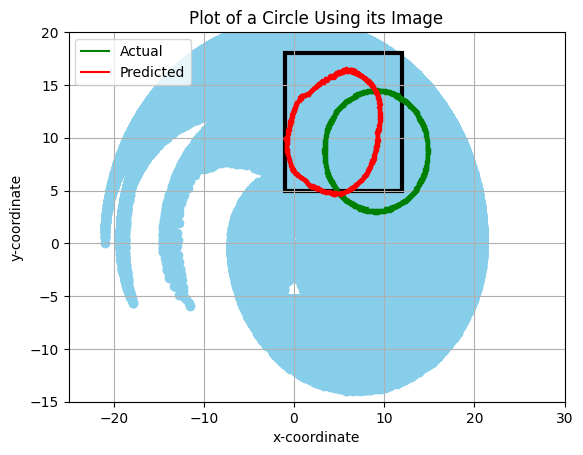

<Figure size 1500x1500 with 0 Axes>

In [46]:
plotCoordinateFile("Image_Generated/Image Generate_Circle.csv", 'Plot of a Circle Using its Image')

In [47]:
getPerformanceModel("Image_Generated/Image Generate_Circle.csv")

Mean Squared Error in x  : 0.46441939130434784
Mean Squared Error in y  : 0.48890843478260865
Mean Squared Error in q1 : 2.267725922658471
Mean Squared Error in q2 : 0.0007529727720041263
Mean Squared Error in q3 : 2.268495163464788
Mean Squared Error in theta : 2.0727185995990256

Root Mean Squared Error in x : 0.6814832289237556
Root Mean Squared Error in y : 0.6992198758492272
Root Mean Squared Error in q1 : 1.505897049156572
Root Mean Squared Error in q2 : 0.027440349341874753
Root Mean Squared Error in q3 : 1.506152436994605
Root Mean Squared Error in theta : 1.4396939256658081

Mean Absolute Error in x : 0.44007826086956525
Mean Absolute Error in y : 0.577504347826087
Mean Absolute Error in q1 : 1.2318876220732116
Mean Absolute Error in q2 : 0.007157653886011344
Mean Absolute Error in q3 : 1.237833591382531
Mean Absolute Error in theta : 1.1050261079093162

R2 Score for x : 0.9718233150934119
R2 Score for y : 0.9699269977340067
R2 Score for q1 : -5.2173369185026806
R2 Score for q

Plot a Triangle from its Image

In [48]:
generateCoordinateFile('Images/Image_Triangle.png', 'Image_Generated', 'Triangle')

1/1 [==============================] - 0s 13ms/step


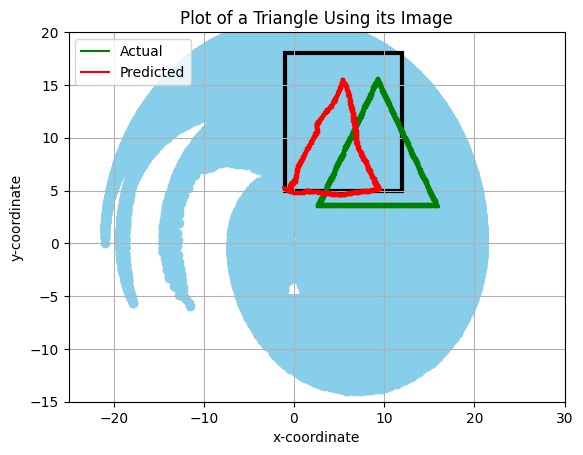

<Figure size 1500x1500 with 0 Axes>

In [49]:
plotCoordinateFile("Image_Generated/Image Generate_Triangle.csv", 'Plot of a Triangle Using its Image')

In [50]:
getPerformanceModel("Image_Generated/Image Generate_Triangle.csv")

Mean Squared Error in x  : 0.45171026252983293
Mean Squared Error in y  : 0.41490859188544155
Mean Squared Error in q1 : 1.7240789450658602
Mean Squared Error in q2 : 0.027797425630428994
Mean Squared Error in q3 : 1.7518910620817387
Mean Squared Error in theta : 2.0320003621992404

Root Mean Squared Error in x : 0.6720939387688546
Root Mean Squared Error in y : 0.6441339859729818
Root Mean Squared Error in q1 : 1.3130418672174395
Root Mean Squared Error in q2 : 0.16672559980527585
Root Mean Squared Error in q3 : 1.3235902168276021
Root Mean Squared Error in theta : 1.4254825015408783

Mean Absolute Error in x : 0.43815433571996815
Mean Absolute Error in y : 0.5009307875894988
Mean Absolute Error in q1 : 0.966060719379847
Mean Absolute Error in q2 : 0.05531239922740994
Mean Absolute Error in q3 : 1.0201631711122445
Mean Absolute Error in theta : 1.1181903197600147

R2 Score for x : 0.968451482258858
R2 Score for y : 0.9736684796142934
R2 Score for q1 : -4.315967652063214
R2 Score for q

Plot a Pentagon from its Image

In [51]:
generateCoordinateFile('Images/Image_Pentagon.png', 'Image_Generated', 'Pentagon')

1/1 [==============================] - 0s 19ms/step


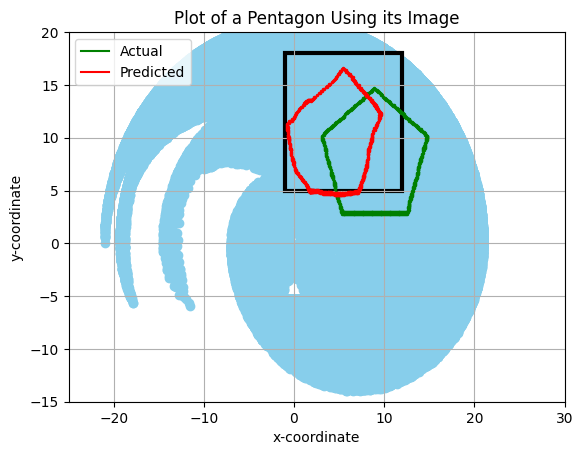

<Figure size 1500x1500 with 0 Axes>

In [52]:
plotCoordinateFile("Image_Generated/Image Generate_Pentagon.csv", 'Plot of a Pentagon Using its Image')

In [53]:
getPerformanceModel("Image_Generated/Image Generate_Pentagon.csv")

Mean Squared Error in x  : 0.33085742574257426
Mean Squared Error in y  : 0.33600643564356425
Mean Squared Error in q1 : 2.7188830955862704
Mean Squared Error in q2 : 0.0011685640407433841
Mean Squared Error in q3 : 2.7201322086006887
Mean Squared Error in theta : 1.9290285534026637

Root Mean Squared Error in x : 0.5752020738336869
Root Mean Squared Error in y : 0.5796606210909658
Root Mean Squared Error in q1 : 1.6489036040916007
Root Mean Squared Error in q2 : 0.034184265982223225
Root Mean Squared Error in q3 : 1.6492823313795273
Root Mean Squared Error in theta : 1.3888947236571474

Mean Absolute Error in x : 0.36326732673267326
Mean Absolute Error in y : 0.4701155115511551
Mean Absolute Error in q1 : 1.3639786707236212
Mean Absolute Error in q2 : 0.011595992299728318
Mean Absolute Error in q3 : 1.3736064621904518
Mean Absolute Error in theta : 1.0974637910521465

R2 Score for x : 0.9744207528097171
R2 Score for y : 0.9796648852366567
R2 Score for q1 : -6.988338019436069
R2 Score 

Plot a Square from its Image

In [55]:
generateCoordinateFile('Images/Image_Square.png', 'Image_Generated', 'Square')

1/1 [==============================] - 0s 16ms/step


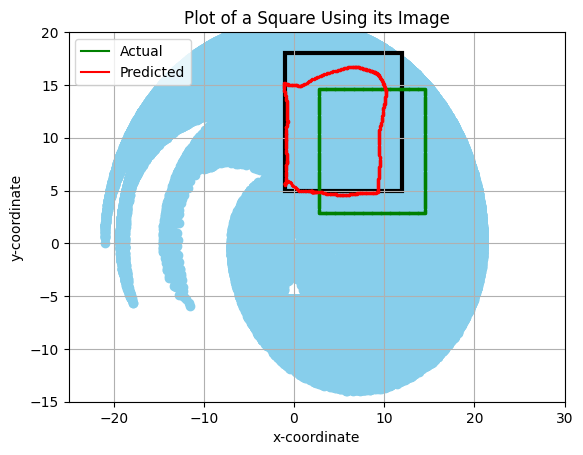

<Figure size 1500x1500 with 0 Axes>

In [56]:
plotCoordinateFile("Image_Generated/Image Generate_Square.csv", 'Plot of a Square Using its Image')

In [57]:
getPerformanceModel("Image_Generated/Image Generate_Square.csv")

Mean Squared Error in x  : 0.37642414529914525
Mean Squared Error in y  : 0.40460106837606846
Mean Squared Error in q1 : 1.7106914988550685
Mean Squared Error in q2 : 0.027025109527966846
Mean Squared Error in q3 : 1.7434049731921024
Mean Squared Error in theta : 1.9561950925779692

Root Mean Squared Error in x : 0.6135341435479734
Root Mean Squared Error in y : 0.6360825955613535
Root Mean Squared Error in q1 : 1.3079340575331269
Root Mean Squared Error in q2 : 0.16439315535619736
Root Mean Squared Error in q3 : 1.3203806167890009
Root Mean Squared Error in theta : 1.3986404443522893

Mean Absolute Error in x : 0.3985683760683761
Mean Absolute Error in y : 0.488440170940171
Mean Absolute Error in q1 : 0.9652475878104955
Mean Absolute Error in q2 : 0.05406841062285796
Mean Absolute Error in q3 : 1.0178915638318795
Mean Absolute Error in theta : 1.0760076048621572

R2 Score for x : 0.9835016262698063
R2 Score for y : 0.9822666539299725
R2 Score for q1 : -2.883025780402495
R2 Score for q

Plot a Hexagon from its Image

In [58]:
generateCoordinateFile('Images/Image_Hexagon.png', 'Image_Generated', 'Hexagon')

1/1 [==============================] - 0s 25ms/step


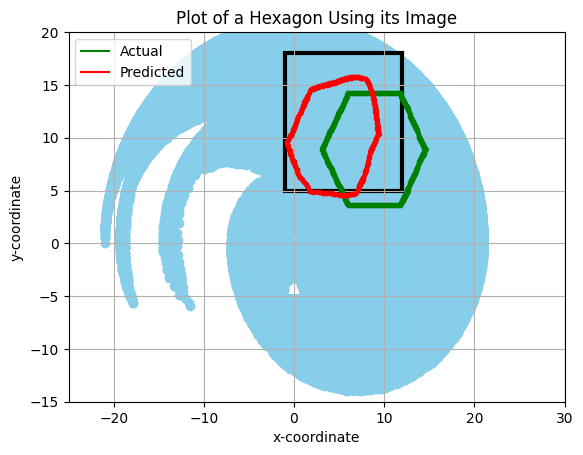

<Figure size 1500x1500 with 0 Axes>

In [59]:
plotCoordinateFile("Image_Generated/Image Generate_Hexagon.csv", 'Plot of a Hexagon Using its Image')

In [60]:
getPerformanceModel("Image_Generated/Image Generate_Hexagon.csv")

Mean Squared Error in x  : 0.447667027027027
Mean Squared Error in y  : 0.44715783783783786
Mean Squared Error in q1 : 2.4320386388783497
Mean Squared Error in q2 : 3.3213498107148906e-05
Mean Squared Error in q3 : 2.432111771760534
Mean Squared Error in theta : 2.0568692132965856

Root Mean Squared Error in x : 0.6690792382274516
Root Mean Squared Error in y : 0.6686986151008822
Root Mean Squared Error in q1 : 1.559499483449209
Root Mean Squared Error in q2 : 0.005763115312671516
Root Mean Squared Error in q3 : 1.5595229308222864
Root Mean Squared Error in theta : 1.434178933500484

Mean Absolute Error in x : 0.4363063063063063
Mean Absolute Error in y : 0.5576036036036036
Mean Absolute Error in q1 : 1.3016145082301094
Mean Absolute Error in q2 : 0.001474706150783828
Mean Absolute Error in q3 : 1.3019455331416123
Mean Absolute Error in theta : 1.1293448715838774

R2 Score for x : 0.9682310978148685
R2 Score for y : 0.9706700147411048
R2 Score for q1 : -6.797229369240742
R2 Score for q

## GENERATING A PLOT FROM INPUT TEXT

In [61]:
if not os.path.exists("Text_Generated"):
    os.makedirs("Text_Generated")

In [62]:
def text_to_image(text, font_size, image_width, 
                  image_height, output_path) :

    image = Image.new("RGB", 
                      (image_width, image_height), 
                      (255, 255, 255))

    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype("arial.ttf", font_size)

    _, _, text_width, text_height = draw.textbbox((0, 0), 
                                                  text=text, 
                                                  font=font)

    x = 60
    y = image_height - text_height - 30

    draw.text((x, y), text, font = font, fill = (0, 0, 0))

    image.save(output_path)

Plotting the Word "SAATVIK" from Text Input

In [64]:
text_to_image("SAATVIK", 30, 300, 100, "Text_Generated/Text Generate_SAATVIK.png")

In [65]:
generateCoordinateFile('Text_Generated/Text Generate_SAATVIK.png', 'Text_Generated', "SAATVIK")

1/1 [==============================] - 0s 49ms/step


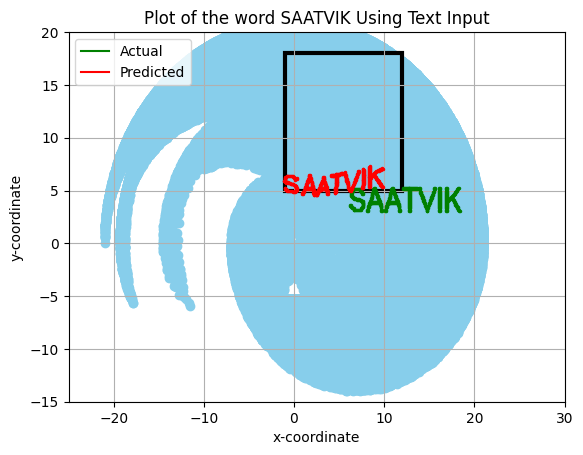

<Figure size 1500x1500 with 0 Axes>

In [66]:
plotCoordinateFile("Text_Generated/Image Generate_SAATVIK.csv", 'Plot of the word SAATVIK Using Text Input')

In [67]:
getPerformanceModel("Text_Generated/Image Generate_SAATVIK.csv")

Mean Squared Error in x  : 0.0646844106463878
Mean Squared Error in y  : 0.16490323193916345
Mean Squared Error in q1 : 3.108053719088798
Mean Squared Error in q2 : 2.7586868616297633e-07
Mean Squared Error in q3 : 3.1079290809032893
Mean Squared Error in theta : 1.5534623168783888

Root Mean Squared Error in x : 0.25433130095681855
Root Mean Squared Error in y : 0.40608278951362053
Root Mean Squared Error in q1 : 1.7629673051672847
Root Mean Squared Error in q2 : 0.0005252320307854199
Root Mean Squared Error in q3 : 1.7629319558347365
Root Mean Squared Error in theta : 1.2463796840764008

Mean Absolute Error in x : 0.20619771863117872
Mean Absolute Error in y : 0.37195817490494293
Mean Absolute Error in q1 : 1.5143710101045529
Mean Absolute Error in q2 : 0.0004315772275412284
Mean Absolute Error in q3 : 1.5143277559985795
Mean Absolute Error in theta : 0.9972526966886599

R2 Score for x : 0.9950935173930512
R2 Score for y : 0.5964635556744282
R2 Score for q1 : -20.03702701753091
R2 Sc

Plotting the Word "MANIT" from Text Input

In [68]:
text_to_image("MANIT", 30, 300, 100, "Text_Generated/Text Generate_MANIT.png")

In [70]:
generateCoordinateFile('Text_Generated/Text Generate_MANIT.png', 'Text_Generated', "MANIT")

1/1 [==============================] - 0s 17ms/step


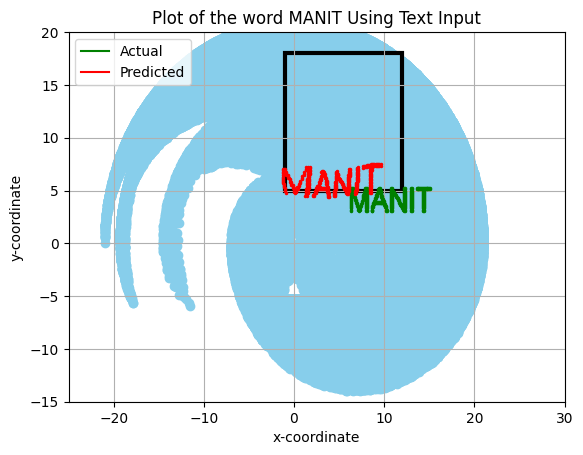

<Figure size 1500x1500 with 0 Axes>

In [71]:
plotCoordinateFile("Text_Generated/Image Generate_MANIT.csv", 'Plot of the word MANIT Using Text Input')

In [72]:
getPerformanceModel("Text_Generated/Image Generate_MANIT.csv")

Mean Squared Error in x  : 0.05617027027027026
Mean Squared Error in y  : 0.16146261261261263
Mean Squared Error in q1 : 4.099474362070428
Mean Squared Error in q2 : 2.1626164050735068e-07
Mean Squared Error in q3 : 4.099414918296302
Mean Squared Error in theta : 1.9245383399239782

Root Mean Squared Error in x : 0.23700267987993354
Root Mean Squared Error in y : 0.40182410655983875
Root Mean Squared Error in q1 : 2.0247158719362153
Root Mean Squared Error in q2 : 0.0004650393967260738
Root Mean Squared Error in q3 : 2.0247011923482194
Root Mean Squared Error in theta : 1.387277311832057

Mean Absolute Error in x : 0.1802702702702703
Mean Absolute Error in y : 0.3615315315315315
Mean Absolute Error in q1 : 1.8956903199644308
Mean Absolute Error in q2 : 0.00040394274199401274
Mean Absolute Error in q3 : 1.895668203449965
Mean Absolute Error in theta : 1.113951591763827

R2 Score for x : 0.9915094825548465
R2 Score for y : 0.6143997980299194
R2 Score for q1 : -45.45473198646623
R2 Score 

Plotting the Word "ROBOT" from Text Input

In [73]:
text_to_image("ROBOT", 30, 300, 100, "Text_Generated/Text Generate_ROBOT.png")

In [74]:
generateCoordinateFile('Text_Generated/Text Generate_ROBOT.png', 'Text_Generated', "ROBOT")

1/1 [==============================] - 0s 19ms/step


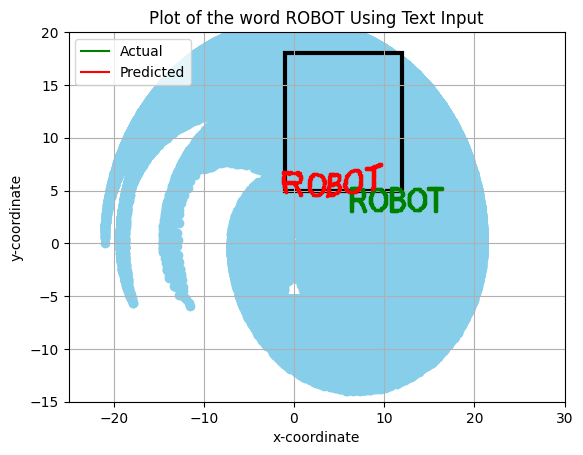

<Figure size 1500x1500 with 0 Axes>

In [75]:
plotCoordinateFile("Text_Generated/Image Generate_ROBOT.csv", 'Plot of the word ROBOT Using Text Input')

In [76]:
getPerformanceModel("Text_Generated/Image Generate_ROBOT.csv")

Mean Squared Error in x  : 0.04536141078838176
Mean Squared Error in y  : 0.15133692946058092
Mean Squared Error in q1 : 3.745101123871807
Mean Squared Error in q2 : 2.094566827580503e-07
Mean Squared Error in q3 : 3.7449631518363136
Mean Squared Error in theta : 1.8176734417290008

Root Mean Squared Error in x : 0.21298218420417647
Root Mean Squared Error in y : 0.3890204743462494
Root Mean Squared Error in q1 : 1.935226375355557
Root Mean Squared Error in q2 : 0.00045766437785570586
Root Mean Squared Error in q3 : 1.9351907275088711
Root Mean Squared Error in theta : 1.348211200713375

Mean Absolute Error in x : 0.16863070539419095
Mean Absolute Error in y : 0.3478423236514523
Mean Absolute Error in q1 : 1.7295457405273382
Mean Absolute Error in q2 : 0.0003877837942962408
Mean Absolute Error in q3 : 1.7295151458228268
Mean Absolute Error in theta : 1.06974876553947

R2 Score for x : 0.995146829692345
R2 Score for y : 0.6653079650804321
R2 Score for q1 : -27.090368295092613
R2 Score f

Plotting the Word "ROBOTICS" from Text Input

In [77]:
text_to_image("ROBOTICS", 26, 300, 100, "Text_Generated/Text Generate_ROBOTICS.png")

In [79]:
generateCoordinateFile('Text_Generated/Text Generate_ROBOTICS.png', 'Text_Generated', "ROBOTICS")

1/1 [==============================] - 0s 19ms/step


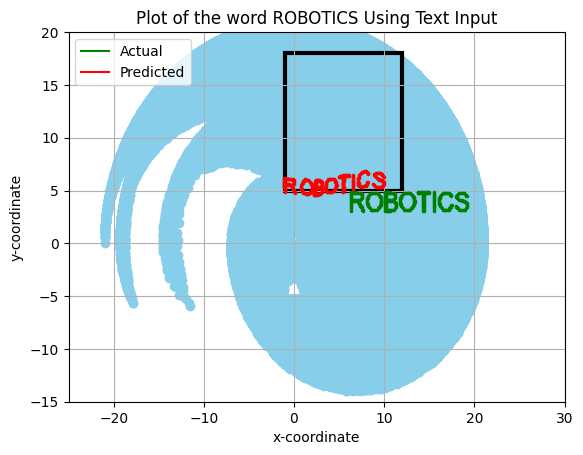

<Figure size 1500x1500 with 0 Axes>

In [80]:
plotCoordinateFile("Text_Generated/Image Generate_ROBOTICS.csv", 'Plot of the word ROBOTICS Using Text Input')

In [81]:
getPerformanceModel("Text_Generated/Image Generate_ROBOTICS.csv")

Mean Squared Error in x  : 0.08780977777777782
Mean Squared Error in y  : 0.16100711111111107
Mean Squared Error in q1 : 3.2553091328631005
Mean Squared Error in q2 : 3.1085024482176155e-07
Mean Squared Error in q3 : 3.2551672139045165
Mean Squared Error in theta : 1.612205692200587

Root Mean Squared Error in x : 0.2963271465420909
Root Mean Squared Error in y : 0.40125691409757797
Root Mean Squared Error in q1 : 1.8042475253864423
Root Mean Squared Error in q2 : 0.0005575394558430476
Root Mean Squared Error in q3 : 1.804208195831212
Root Mean Squared Error in theta : 1.26972662104903

Mean Absolute Error in x : 0.22466666666666674
Mean Absolute Error in y : 0.36093333333333333
Mean Absolute Error in q1 : 1.5812231954250855
Mean Absolute Error in q2 : 0.0004533415653162947
Mean Absolute Error in q3 : 1.581185141020769
Mean Absolute Error in theta : 1.043181289669005

R2 Score for x : 0.9938776834246336
R2 Score for y : 0.540125090606272
R2 Score for q1 : -16.428383183026405
R2 Score f

Plotting the Word "3 LINK" from Text Input

In [82]:
text_to_image("3 LINK", 30, 300, 100, "Text_Generated/Text Generate_3 LINK.png")

In [83]:
generateCoordinateFile('Text_Generated/Text Generate_3 LINK.png', 'Text_Generated', "3 LINK")

1/1 [==============================] - 0s 50ms/step


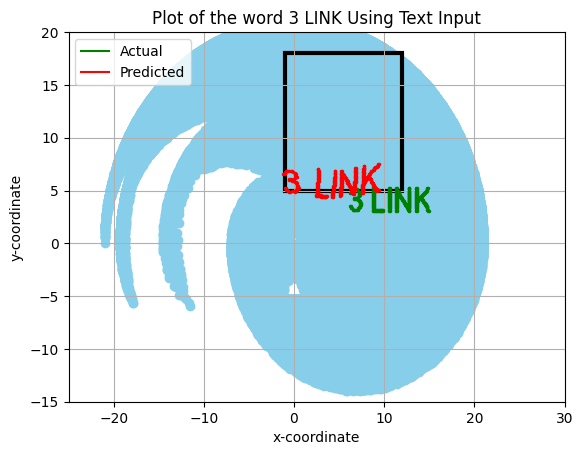

<Figure size 1500x1500 with 0 Axes>

In [84]:
plotCoordinateFile("Text_Generated/Image Generate_3 LINK.csv", 'Plot of the word 3 LINK Using Text Input')

In [85]:
getPerformanceModel("Text_Generated/Image Generate_3 LINK.csv")

Mean Squared Error in x  : 0.03771087533156492
Mean Squared Error in y  : 0.15765092838196285
Mean Squared Error in q1 : 3.6377503284395303
Mean Squared Error in q2 : 2.0284355322161472e-07
Mean Squared Error in q3 : 3.637641214601183
Mean Squared Error in theta : 1.4506916761837128

Root Mean Squared Error in x : 0.19419288177367605
Root Mean Squared Error in y : 0.39705280301486706
Root Mean Squared Error in q1 : 1.9072887375642762
Root Mean Squared Error in q2 : 0.00045038156403389194
Root Mean Squared Error in q3 : 1.90726013291349
Root Mean Squared Error in theta : 1.2044466265400524

Mean Absolute Error in x : 0.13989389920424397
Mean Absolute Error in y : 0.35931034482758617
Mean Absolute Error in q1 : 1.7839919788850935
Mean Absolute Error in q2 : 0.00038084096576175704
Mean Absolute Error in q3 : 1.7839613401039731
Mean Absolute Error in theta : 0.9349679336003963

R2 Score for x : 0.9936426836981761
R2 Score for y : 0.6248413792826321
R2 Score for q1 : -47.61189623122072
R2 S

Plotting the Word "BHOPAL" from Text Input

In [86]:
text_to_image("BHOPAL", 30, 300, 100, "Text_Generated/Text Generate_BHOPAL.png")

In [87]:
generateCoordinateFile('Text_Generated/Text Generate_BHOPAL.png', 'Text_Generated', "BHOPAL")

1/1 [==============================] - 0s 20ms/step


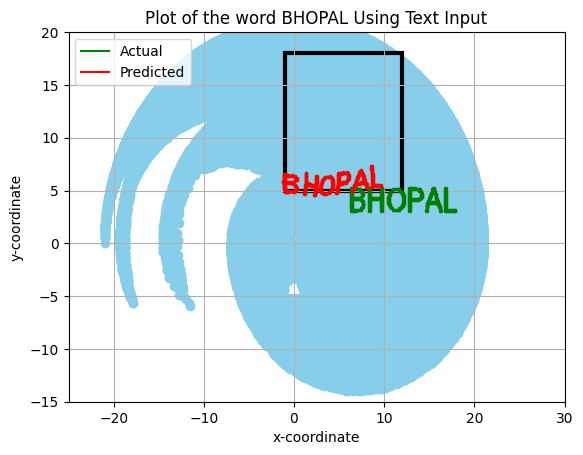

<Figure size 1500x1500 with 0 Axes>

In [88]:
plotCoordinateFile("Text_Generated/Image Generate_BHOPAL.csv", 'Plot of the word BHOPAL Using Text Input')

In [89]:
getPerformanceModel("Text_Generated/Image Generate_BHOPAL.csv")

Mean Squared Error in x  : 0.056366431095406344
Mean Squared Error in y  : 0.14531007067137808
Mean Squared Error in q1 : 3.432467129631612
Mean Squared Error in q2 : 2.2848660304911662e-07
Mean Squared Error in q3 : 3.4324201953691453
Mean Squared Error in theta : 1.762231687770371

Root Mean Squared Error in x : 0.23741615592753232
Root Mean Squared Error in y : 0.38119558060315717
Root Mean Squared Error in q1 : 1.8526918604105789
Root Mean Squared Error in q2 : 0.0004780027228469694
Root Mean Squared Error in q3 : 1.8526791938619986
Root Mean Squared Error in theta : 1.327490748657169

Mean Absolute Error in x : 0.1839575971731449
Mean Absolute Error in y : 0.34408127208480566
Mean Absolute Error in q1 : 1.607430909642942
Mean Absolute Error in q2 : 0.00039873522968784497
Mean Absolute Error in q3 : 1.6074228785428453
Mean Absolute Error in theta : 1.0440351593973896

R2 Score for x : 0.9954839667619122
R2 Score for y : 0.6444719382214094
R2 Score for q1 : -20.170995779932916
R2 Sc

Plotting the Word "RESEARCH" from Text Input

In [90]:
text_to_image("RESEARCH", 26, 300, 100, "Text_Generated/Text Generate_RESEARCH.png")

In [92]:
generateCoordinateFile('Text_Generated/Text Generate_RESEARCH.png', 'Text_Generated', "RESEARCH")

1/1 [==============================] - 0s 16ms/step


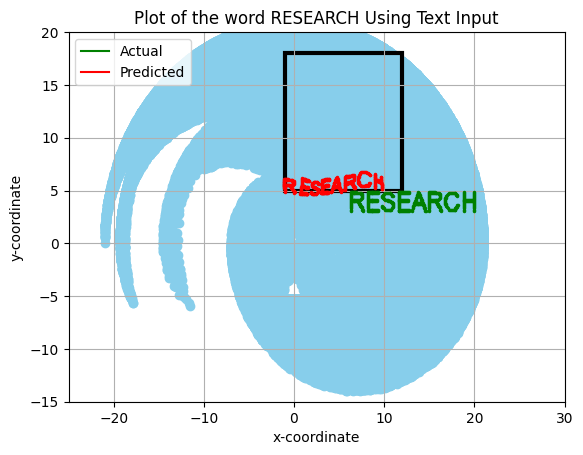

<Figure size 1500x1500 with 0 Axes>

In [93]:
plotCoordinateFile("Text_Generated/Image Generate_RESEARCH.csv", 'Plot of the word RESEARCH Using Text Input')

In [94]:
getPerformanceModel("Text_Generated/Image Generate_RESEARCH.csv")

Mean Squared Error in x  : 0.09314695817490497
Mean Squared Error in y  : 0.13152072243346008
Mean Squared Error in q1 : 3.0551653974999105
Mean Squared Error in q2 : 6.845271794845686e-07
Mean Squared Error in q3 : 3.055260694620599
Mean Squared Error in theta : 1.6429436650873608

Root Mean Squared Error in x : 0.3051998659483732
Root Mean Squared Error in y : 0.3626578586401515
Root Mean Squared Error in q1 : 1.7479031430545315
Root Mean Squared Error in q2 : 0.0008273615772348681
Root Mean Squared Error in q3 : 1.7479304032542597
Root Mean Squared Error in theta : 1.2817736403465945

Mean Absolute Error in x : 0.23366920152091258
Mean Absolute Error in y : 0.3245437262357415
Mean Absolute Error in q1 : 1.4941374480574654
Mean Absolute Error in q2 : 0.0005515804030735357
Mean Absolute Error in q3 : 1.4942064803527348
Mean Absolute Error in theta : 1.0296979969918985

R2 Score for x : 0.9943006182443109
R2 Score for y : 0.6181030054611545
R2 Score for q1 : -12.836727666151166
R2 Scor